In [1]:
import os
import sys
import mlflow
import warnings
import time
import json
import shap
import gc
import subprocess

import pandas as pd
import seaborn as sns
import numpy as np

from hyperopt import fmin, tpe, hp, Trials, space_eval
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

sys.path.append("../")

from scripts.mlflow_functions import train_and_log
from models.scorer import home_credit_scoring_fn, home_credit_scorer, hc_threshold_score

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100

client = mlflow.MlflowClient(tracking_uri=os.path.abspath("../mlruns/"))

mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))


In [2]:
try:
    mlflow.create_experiment(name="home_credit_model")
except mlflow.MlflowException:
    mlflow.set_experiment(experiment_name="home_credit_model")


In [3]:
df_model = pd.read_pickle(filepath_or_buffer="../data/df_hc_nm.pkl")


In [4]:
df_model.head()


,TARGET,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,PREV_PRODUCT_COMBINATION_Cash X-Sell: high_mean,PREV_PRODUCT_COMBINATION_Cash X-Sell: low_mean,PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_mean,PREV_PRODUCT_COMBINATION_POS household with interest_mean,PREV_PRODUCT_COMBINATION_POS household without interest_mean,PREV_PRODUCT_COMBINATION_POS industry with interest_mean,PREV_PRODUCT_COMBINATION_POS industry without interest_mean,PREV_PRODUCT_COMBINATION_POS mobile with interest_mean,PREV_PRODUCT_COMBINATION_POS mobile without interest_mean,PREV_number_applications
0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
26,0,0,0,0,112500.0,979992.0,27076.5,702000.0,0.018029,-18724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,0,0,0,0,202500.0,1193580.0,35028.0,855000.0,0.025164,-17482,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,6.0
42,0,0,1,0,135000.0,288873.0,16258.5,238500.0,0.007305,-13384,...,0.000000,0.0,0.2,0.2,0.0,0.0,0.0,0.400000,0.0,5.0
45,1,0,0,1,90000.0,180000.0,9000.0,180000.0,0.009334,-7974,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,2.0


In [5]:
df_model.rename(columns={"TARGET": "Loan_granted"}, inplace=True)

target_col = "Loan_granted"


In [6]:
target_col = "Loan_granted"


# 1 : Modelisation and experimentation

- Threshold optimization : The first xgboost run will be used to adjust the threshold of the scorer
- Models : Ensemble methods, handle missing values and don't require scaling
    - xGBoost
    - CatBoost
    - LightGBM
- Optimization : Best method will be determined via benchmark
    - GridSearchCV
    - Hyperopt
- Logging via MlFlow :
    - Metrics
    - Custom metric tuning
    - AUROC, confusion matrix
    - Global feature importance
    - Model
    - Method of undersampling
    - Version (handling of nans.)

<hr>


In [7]:
# Splitting the data into training, validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df_model.drop(columns=target_col),
    df_model[target_col],
    test_size=0.3,
    random_state=123
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25,
    random_state=123
    )


## 1.1 xGBoost

### Hyperopt optimization

In [8]:
xgb_param_space = {
    "n_estimators": hp.choice("n_estimators", np.arange(200, 800, 25, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(3, 9, dtype=int)),
    "learning_rate": hp.loguniform("learning_rate", -7, -3),
    "min_child_weight": hp.quniform("min_child_weight", 1, 6, 0.1),
    "reg_alpha": hp.loguniform("reg_alpha", -6, -3),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -3),
    "subsample": hp.uniform("subsample", 0.5, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 0.9),
    "nthread": -1
}

def objective(params):
    model = XGBClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        min_child_weight=params["min_child_weight"],
        reg_alpha=params["reg_alpha"],
        reg_lambda=params["reg_lambda"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        nthread=params["nthread"]
    )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=home_credit_scorer)
    loss = -np.mean(scores)
    return {"loss": loss, "status": "ok"}


trials = Trials()

time_start_hopt = time.perf_counter()
best = fmin(objective, space=xgb_param_space, algo=tpe.suggest, max_evals=20, trials=trials)
time_end_hopt = time.perf_counter()

print(f"Hyperopt search time: {time_end_hopt - time_start_hopt} seconds.")


 40%|████      | 8/20 [15:16<20:24, 102.04s/trial, best loss: 3.6742878557992675]  

In [ ]:
best_params_xgb = space_eval(xgb_param_space, best)
gc.collect()
print(best_params_xgb)


{'colsample_bytree': 0.5009138282268638, 'learning_rate': 0.010415163767282878, 'max_depth': 6, 'min_child_weight': 5.1000000000000005, 'n_estimators': 325, 'nthread': -1, 'reg_alpha': 0.0026552885708914066, 'reg_lambda': 0.009647834136060898, 'subsample': 0.7591990365533907}


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
eval_metric is not saved in Scikit-Learn meta.
Setuptools is replacing distutils.
Successfully registered model 'xgboost_metric_calibration_run'.
2023/03/05 16:48:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost_metric_calibration_run, version 1
Created version '1' of model 'xgboost_metric_calibration_run'.
Registered model 'xgboost_metric_calibration_run' already exists. Creating a new version of this model...
2023/03/05 16:48:10 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: xgboost_metric_calibration_run, version 2
Created version '2' of model 'xgboost_metric_calibration_run'.


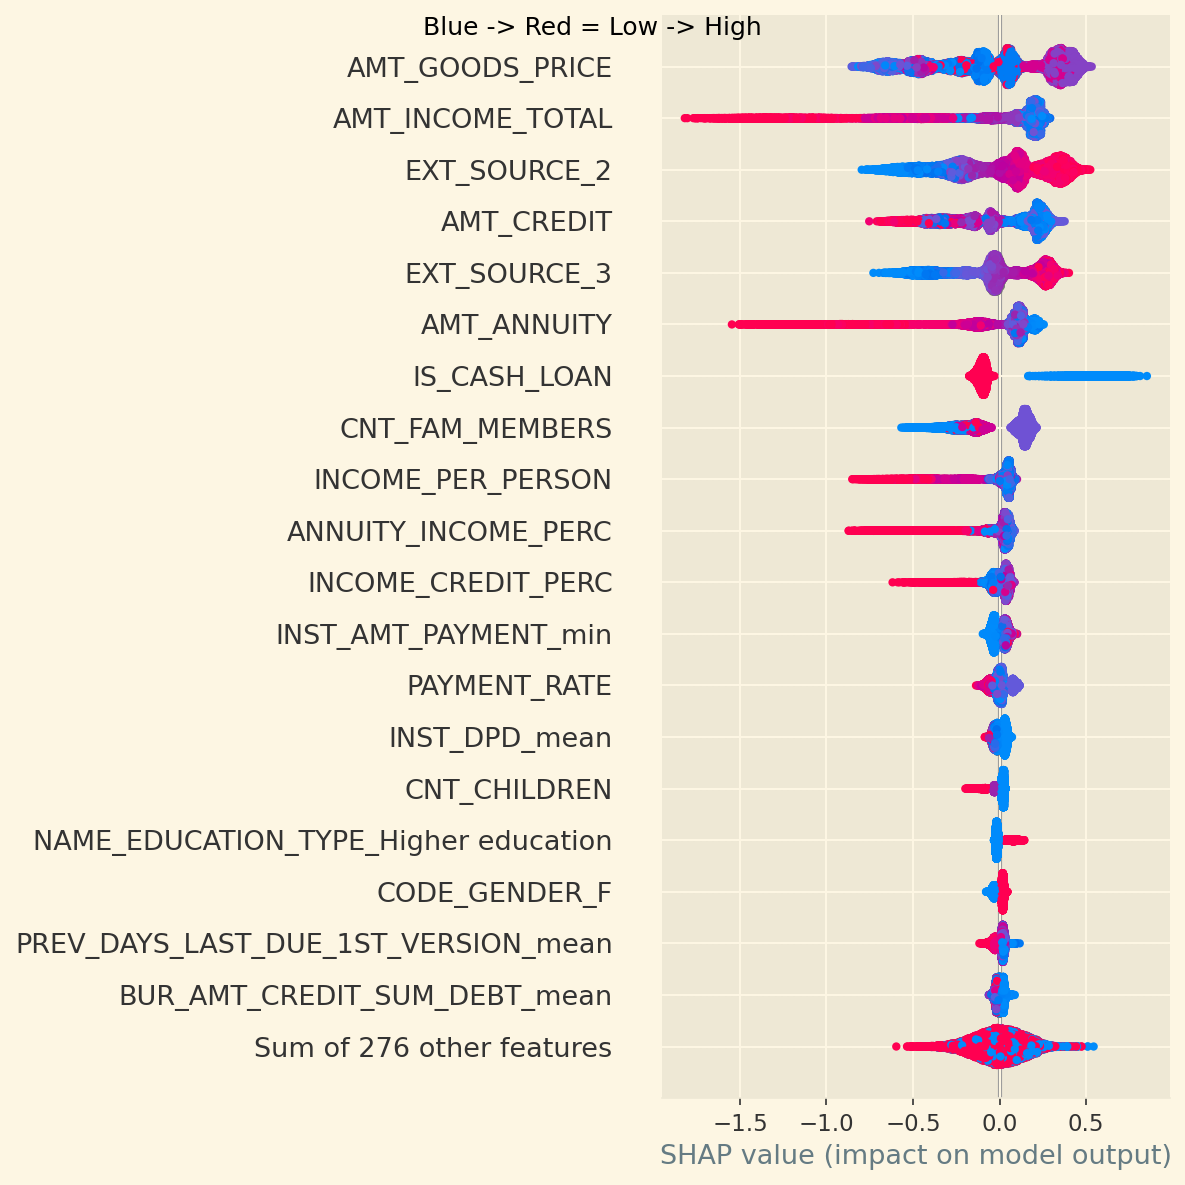

In [10]:
mlflow.set_experiment(experiment_name="home_credit_model")

best_params_xgb_log = {
    'colsample_bytree': 0.5009138282268638,
    'learning_rate': 0.010415163767282878,
    'max_depth': 6,
    'min_child_weight': 5.1000000000000005,
    'n_estimators': 325,
    'reg_alpha': 0.0026552885708914066,
    'reg_lambda': 0.009647834136060898,
    'subsample': 0.7591990365533907
    }

xgb_metrics, xgb_clf = train_and_log(
    estimator=XGBClassifier,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    dataset_version="nans_kept_shap_reduced",
    imb_method="near_miss_one",
    na_thresh=0,
    params=best_params_xgb_log,
    model_name="xgboost_metric_calibration_run",
)


In [4]:
# There might be overfitting, we will try and adjust it

y_proba = xgb_clf.predict_proba(X_val)

optimal_threshold = hc_threshold_score(y_val, y_proba)

y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

score = home_credit_scoring_fn(y_val, y_pred)
print("Score:", score)


NameError: name 'xgb_clf' is not defined

### Observations :
With an AUC of .881, it might be considered that the model is overfitting - or the fact that the competition is quite old in a machine learning POV might explain why xGboost is having such high performances.

## 1.2 : Catboost :

In [ ]:
catboost_param_space = {
    "iterations": hp.choice("iterations", np.arange(500, 1500, 100, dtype=int)),
    "depth": hp.choice("depth", np.arange(5, 11, dtype=int)),
    "learning_rate": hp.loguniform("learning_rate", -5, -1),
    "l2_leaf_reg": hp.loguniform("l2_leaf_reg", -3, 0),
    "random_strength": hp.uniform("random_strength", 0, 0.5),
}


def objective_cb(params):
    model = CatBoostClassifier(
        iterations=params["iterations"],
        depth=params["depth"],
        learning_rate=params["learning_rate"],
        l2_leaf_reg=params["l2_leaf_reg"],
        random_strength=params["random_strength"]
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=home_credit_scorer)
    loss = -np.mean(scores)
    return {"loss": loss, "status": "ok"}

trials = Trials()

time_start_hopt = time.perf_counter()
best_cb = fmin(objective_cb, space=catboost_param_space, algo=tpe.suggest, max_evals=20, trials=trials)
time_end_hopt = time.perf_counter()

print(f"Hyperopt search time: {time_end_hopt - time_start_hopt} seconds.")


In [ ]:
best_params_cb = space_eval(catboost_param_space, best_cb)
print(best_params_cb)


In [ ]:
mlflow.set_experiment(experiment_name="home_credit_model")

best_params_cb_log = {
    "depth": 6,
    "iterations": 800,
    "l2_leaf_reg": 0.18635478544980705,
    "learning_rate": 0.27474217701367454,
    "random_strength": 0.28765248217892864
    }

cb_metrics, cb_clf = train_and_log(
    estimator=CatBoostClassifier,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    dataset_version="nans_kept_shap_reduced",
    imb_method="near_miss_one",
    na_thresh=0,
    params=best_params_cb_log,
    model_name="catboost_cvalidated",
)


##### The problem of our generic function doesnt account for catboost specific scoring args, will be addressed at the end of the nb by defining again the functions imported for mlflow_function

# LightGBM :

In [ ]:
lgbm_param_space = {
    "n_estimators": hp.choice("n_estimators", np.arange(100, 600, 50, dtype=int)),
    "max_depth": hp.choice("max_depth", np.arange(3, 9, dtype=int)),
    "learning_rate": hp.loguniform("learning_rate", -5, -1),
    "min_child_weight": hp.quniform("min_child_weight", 5, 8, 0.1),
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -5, -1),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "nthread": -1
}


def objective_lgbm(params):
    model = LGBMClassifier(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        learning_rate=params["learning_rate"],
        min_child_weight=params["min_child_weight"],
        reg_alpha=params["reg_alpha"],
        reg_lambda=params["reg_lambda"],
        subsample=params["subsample"],
        colsample_bytree=params["colsample_bytree"],
        nthread=params["nthread"]
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val), eval_metric="auc", verbose=False)
    y_pred = model.predict_proba(X_test)[:, 1]
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=home_credit_scorer)
    loss = -np.mean(scores)
    return {"loss": loss, "status": "ok"}


trials = Trials()

time_start_hopt = time.perf_counter()
best_lgbm = fmin(objective, space=lgbm_param_space, algo=tpe.suggest, max_evals=20, trials=trials)
time_end_hopt = time.perf_counter()

print(f"Hyperopt search time: {time_end_hopt - time_start_hopt} seconds.")


In [ ]:
best_params_lgbm = space_eval(lgbm_param_space, best_lgbm)
print(best_params_lgbm)


In [ ]:
mlflow.set_experiment(experiment_name="home_credit_model")

best_params_lgbm = {
    "colsample_bytree": 0.5409789806938354,
    "learning_rate": 0.33448916799291384,
    "max_depth": 8,
    "min_child_weight": 7.5,
    "n_estimators": 300,
    "reg_alpha": 0.03637888401272048,
    "reg_lambda": 0.006953381725363546,
    "subsample": 0.6097424165224092
    }

lgbm_metrics, lgbm_clf = train_and_log(
    estimator=LGBMClassifier,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    dataset_version="nans_kept_shap_reduced",
    imb_method="near_miss_one",
    na_thresh=0,
    params=best_params_lgbm,
    model_name="lightgbm_cvalidated",
)
